# Регрессия

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [20]:
PATH = "../../Datasets/bikes/"
tr_name = "train.csv"

In [21]:
tr = pd.read_csv(f"{PATH}{tr_name}")

In [22]:
tr['datetime'] = pd.to_datetime(tr['datetime'])
tr['hour'] = tr.datetime.dt.hour
tr['month'] = tr.datetime.dt.month
tr['year'] = tr.datetime.dt.year
tr['dayofweek'] = tr.datetime.dt.dayofweek
tr['day'] = tr.datetime.dt.day
tr['cnt'] = tr['count']
tr.drop(['datetime', 'count', 'casual', 'registered'], axis = 1, inplace = True)

In [23]:
tr.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,year,dayofweek,day,cnt
0,1,0,0,1,9.84,14.395,81,0.0,0,1,2011,5,1,16
1,1,0,0,1,9.02,13.635,80,0.0,1,1,2011,5,1,40
2,1,0,0,1,9.02,13.635,80,0.0,2,1,2011,5,1,32
3,1,0,0,1,9.84,14.395,75,0.0,3,1,2011,5,1,13
4,1,0,0,1,9.84,14.395,75,0.0,4,1,2011,5,1,1


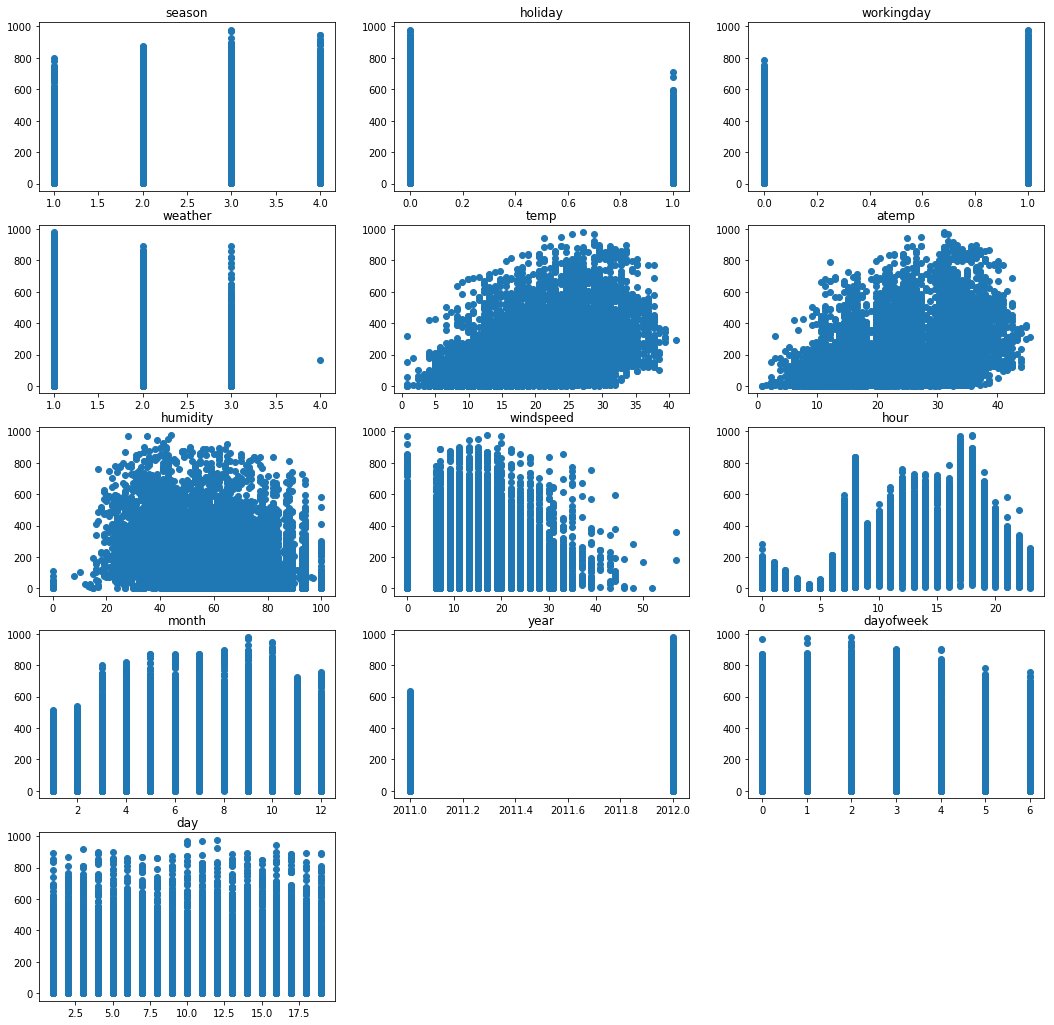

In [36]:
plt.figure(figsize=(18,18))
for i, col in enumerate(tr.columns[:-1]):
    plt.subplot(5, 3, i+1)
    plt.scatter(tr[col], tr['cnt'])
    plt.title(col)

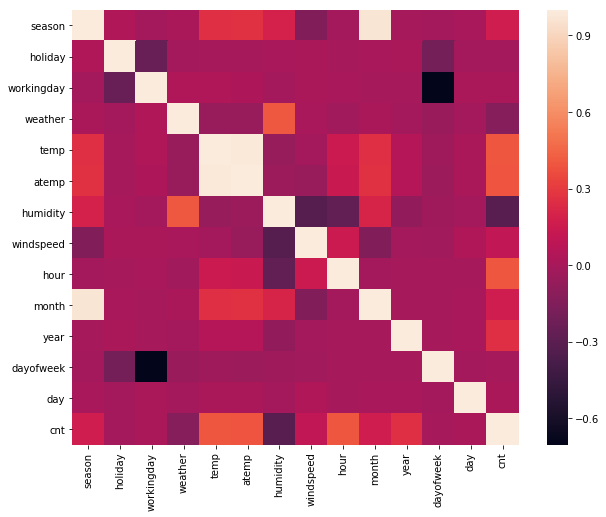

In [41]:
plt.figure(figsize=(10,8))
sns.heatmap(tr.corr());

## Модели

In [42]:
linreg = LinearRegression()
lasso = Lasso(random_state = 42)
lasso_cv = LassoCV(random_state = 42)
ridge = Ridge(random_state = 42)
ridge_cv = RidgeCV()
ranforreg = RandomForestRegressor()

scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

models = [linreg, lasso, lasso_cv, ridge, ridge_cv, ranforreg]
models_name = ['linreg', 'lasso', 'lasso_cv', 'ridge', 'ridge_cv', 'forest']

In [73]:
cat_features = ['season', 'holiday', 'workingday', 'weather', 'hour', 'month', 'year', 'dayofweek', 'day']

In [74]:
X, Y = tr.drop(['cnt','temp'], axis = 1), tr.cnt

In [75]:
X_scal = scaler.fit_transform(X)
X_linear = pd.DataFrame(X_scal, columns = ['season', 'holiday', 'workingday', 'weather',
                                                'atemp', 'humidity', 'windspeed',
                                                'hour', 'month', 'year', 'dayofweek', 'day'])

C:\Users\Fridge\Anaconda3\envs\fastai\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Fridge\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [76]:
encoder.fit(X_linear[cat_features])
X_linear = pd.concat([X_linear.drop(cat_features, axis = 1),
          pd.DataFrame(encoder.transform(X_linear[cat_features]))], axis=1).reindex()

In [77]:
X_linear.head()

,atemp,humidity,windspeed,0,1,2,3,4,5,6,...,66,67,68,69,70,71,72,73,74,75
0,-1.092737,0.993213,-1.567754,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.182421,0.941249,-1.567754,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.182421,0.941249,-1.567754,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.092737,0.681430,-1.567754,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.092737,0.681430,-1.567754,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
def fit_and_res(model, x, y, show_params = False):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)
    model.fit(x_train, y_train)
    mse = mean_squared_error(y_val, model.predict(x_val))
    return (model.best_params_, mse, math.sqrt(mse)) if show_params else (mse, math.sqrt(mse))

In [100]:
res = []
for model in models[:-1]:
    res.append(fit_and_res(model, X_linear, Y))
res.append(fit_and_res(models[-1], X, Y))
res = pd.DataFrame(np.array(res).T, columns = models_name, index = ['mse', 'sqrt'])
res

C:\Users\Fridge\Anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


,linreg,lasso,lasso_cv,ridge,ridge_cv,forest
mse,10113.113479,10932.835773,10115.623117,10112.699214,10112.699214,1740.415195
sqrt,100.563977,104.560202,100.576454,100.561917,100.561917,41.718284


In [123]:
trees = RandomForestRegressor()
param_grid = { 
            "n_estimators"      : range(10, 50, 5),
            "max_features"      : ["auto", "sqrt", "log2"],
            "bootstrap": [True, False],
            }
grid = GridSearchCV(trees, param_grid, n_jobs=-1, cv=5)
forest_res = fit_and_res(grid, X, Y, show_params = True)

In [124]:
res['forest'] = np.array(forest_res[1:]).T
res

,linreg,lasso,lasso_cv,ridge,ridge_cv,forest
mse,10113.113479,10932.835773,10115.623117,10112.699214,10112.699214,1542.889844
sqrt,100.563977,104.560202,100.576454,100.561917,100.561917,39.279637
